<a href="https://colab.research.google.com/github/nomatib/autoencoder/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
def relu(z): #ReLU(z)
  return np.maximum(0, z)
def reluprima(z): #Derivada de ReLU(z)
  return np.where(z > 0, 1, 0)
def relu2(z, c, d): #ReLU(z - c)*ReLU(d - z)
  r2 = np.zeros_like(z)
  mask = (z > c) & (z < d)
  zc = z - c
  zd = d - z
  z = zc * zd
  r2[mask] = z[mask]
  return r2
def relu2dz(z, c, d): #Derivada de ReLU(z - c)*ReLU(d - z) respecto a z: -(z-c) + (d-z): c-z+d-z: c+d-2z
  derivada = np.zeros_like(z)
  mask = (z > c) & (z < d)
  z = c + d - 2*z
  derivada[mask] = z[mask]
  return derivada
def relu2dd (z, c, d): #Derivada de ReLU(z - c)*ReLU(d - z) respecto a d: (z-c)
  derivada = np.zeros_like(z)
  mask = (z > 0) & (z < d)
  z = z - c
  derivada[mask] = z[mask]
  return derivada
def relu2dc (z, c, d): #Derivada de ReLU(z - c)*ReLU(d - z) respecto a c: -(d-z): z - d
  derivada = np.zeros_like(z)
  mask = (z > 0) & (z < d)
  z = z - d
  derivada[mask] = z[mask]
  return derivada
def softmax(logits): #funcion softamax
  logits = logits - np.max(logits, axis = 0, keepdims = True)
  exp = np.exp(logits)
  probabilidades = exp / np.sum(exp, axis = 0, keepdims = True)
  return probabilidades
def crear_capas(lista_capas, X_num_var): #crear capas de la red
  cc = [Capa(lista_capas[0], X_num_var)]
  for i in range(1, len(lista_capas)):
    cc.append(Capa(lista_capas[i], lista_capas[i-1]))
  return cc

In [67]:
class Capa:
  def __init__(self, neuronas, entradas):
    self.W = np.random.normal(0, 0.025, (neuronas, entradas))
    self.b = np.zeros((neuronas, 1))
    self.c = np.random.normal(-0.1, 0.05, (neuronas, 1))
    self.d = np.random.normal(1, 0.05, (neuronas, 1))
  def propagar(self, a_prev):
    self.z = np.dot(self.W, a_prev) + self.b
    #self.a = relu(self.z)
    self.a = relu2(self.z, self.c, self.d)
  def retropropagar(self, dLdz_sig, a_prev, W_sig):
    #self.dLdz = np.dot(W_sig, dLdz_sig)*reluprima(self.z)
    self.dLdz = np.dot(W_sig, dLdz_sig)*relu2dz(self.z, self.c, self.d)
    self.dLdW = np.dot(self.dLdz, a_prev)/self.dLdz.shape[1]
    self.dLdb = np.sum(self.dLdz, axis = 1, keepdims = True)/self.dLdz.shape[1]
    self.dLdc = np.dot(W_sig, dLdz_sig)*relu2dc(self.z, self.c, self.d)/self.dLdz.shape[1]
    self.dLdd = np.dot(W_sig, dLdz_sig)*relu2dd(self.z, self.c, self.d)/self.dLdz.shape[1]
  def actualizar(self, h):
    self.W = self.W - h*self.dLdW
    self.b = self.b - h*self.dLdb
    self.c = self.c - 0.05*np.sum(self.dLdc, axis = 1, keepdims = True)
    self.d = self.d - 0.05*np.sum(self.dLdd, axis = 1, keepdims = True)
class CapaSalida:
  def __init__(self, neuronas, entradas):
    self.W = np.random.normal(0, 0.025, (neuronas, entradas))
    self.b = np.zeros((neuronas, 1))
  def propagar(self, a_prev):
    self.z = np.dot(self.W, a_prev) + self.b
    self.a = (self.z)
  def retropropagar(self, objetivo, a_prev):
    self.dLdz = self.a - objetivo
    self.dLdW = np.dot(self.dLdz, a_prev)/self.dLdz.shape[1]
    self.dLdb = np.sum(self.dLdz, axis = 1, keepdims = True)/self.dLdz.shape[1]
  def actualizar(self, h):
    self.W = self.W - h*self.dLdW
    self.b = self.b - h*self.dLdb

In [68]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#El dataset MNIST tiene forma (60000, 28, 28) para x, y forma (60000,) para y.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#Reshape x_train a (60000,784)
X = x_train.reshape(60000, -1)/255
X = np.array_split(X, 600, axis = 0)

In [69]:
lista_capas = [784, 100] #cada elemento es una capa con m neuronas
C = crear_capas(lista_capas, 784)
salida = CapaSalida(784, lista_capas[-1])
h = 0.1 #tasa de aprendizaje

In [70]:
for epoch in range(3000): #ciclo de entrenamiento
  #Flujo hacia adelante
  C[0].propagar(X[0].T)
  for i in range(1, len(C)):
    C[i].propagar(C[i-1].a)
  salida.propagar(C[-1].a)
  #Retropropagacion
  salida.retropropagar(X[0].T, C[-1].a.T)
  C[-1].retropropagar(salida.dLdz, C[-2].a.T, salida.W.T)
  for i in range(len(C)-2, 0, -1):
    C[i].retropropagar(C[i+1].dLdz, C[i-1].a.T, C[i+1].W.T)
  C[0].retropropagar(C[1].dLdz, X[0], C[1].W.T)
  #actualizar parametros
  salida.actualizar(h)
  for capa in C:
    capa.actualizar(h)
error = (X[0].T - salida.a)**2
error = np.sum(error, axis = 0)/error.shape[1]

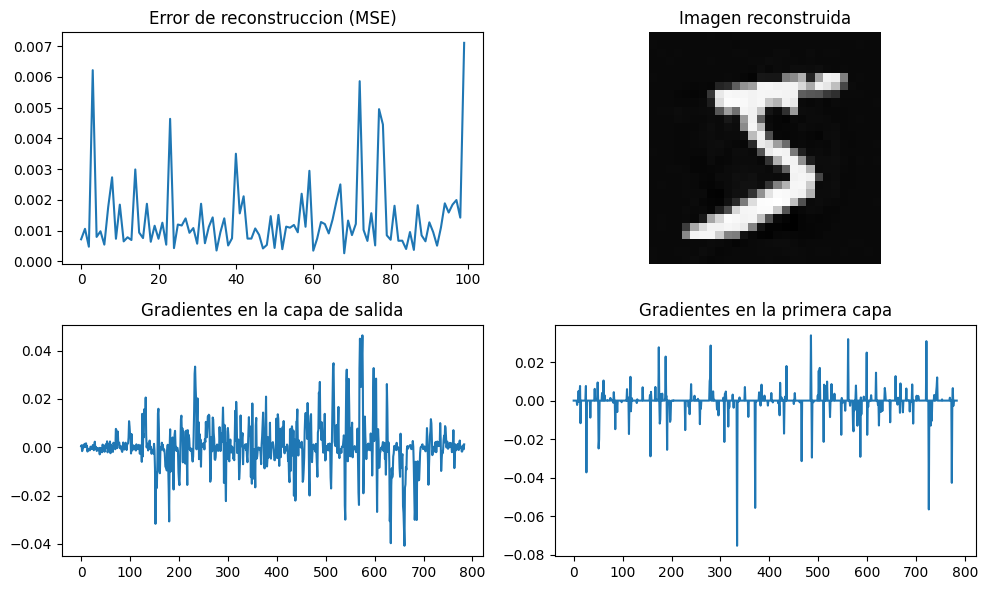

In [71]:
fig, plano = plt.subplots(2, 2, figsize = (10, 6))
plano[0,1].imshow(salida.a[:,0].reshape(28,28), cmap = 'gray')
plano[0,1].set_title("Imagen reconstruida")
plano[0,1].axis('off')
plano[0,0].plot(error)
plano[0,0].set_title("Error de reconstruccion (MSE)")
plano[1,0].plot(salida.dLdz[:,0])
plano[1,0].set_title("Gradientes en la capa de salida")
plano[1,1].plot(C[0].dLdz[:,0])
plano[1,1].set_title("Gradientes en la primera capa")
plt.tight_layout()

In [72]:
np.mean(error)

0.001398544886377496

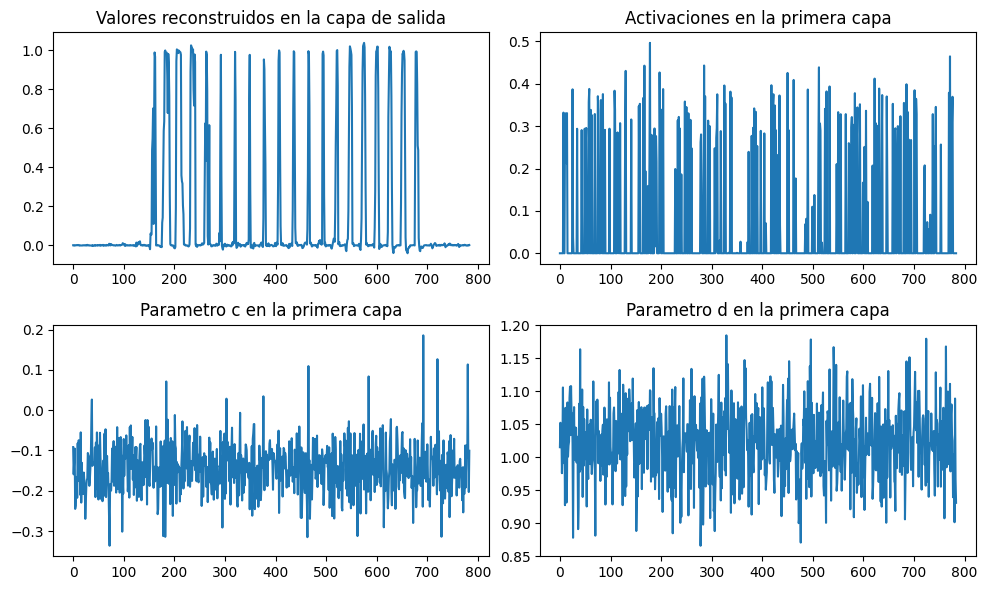

In [73]:
fig, plano = plt.subplots(2, 2, figsize = (10, 6))
plano[0,0].plot(salida.a[:,0])
plano[0,0].set_title("Valores reconstruidos en la capa de salida")
plano[0,1].plot(C[0].a[:,0])
plano[0,1].set_title("Activaciones en la primera capa")
plano[1,0].plot(C[0].c)
plano[1,0].set_title("Parametro c en la primera capa")
plano[1,1].plot(C[0].d)
plano[1,1].set_title("Parametro d en la primera capa")
plt.tight_layout()